# Apprenez une heuristique pour le Go

Dans ce **TP noté**, vous devrez déployer des methodes d'apprentissage automatique permettant d'Ã©valuer la qualité de plateaux de GO.

Pour cela, vous disposerez de 41563 exemples de plateau de Go, tous générés par gnugo après quelques coups contre lui même avec un niveau de difficulté de 0. Par chaque plateau, nous avons lancé 100 matchs de gnugo contre lui même, toujours avec un niveau 0, et compté le nombre de victoires de noir et de blanc depuis ce plateau.

A noter, chaque "rollout" (un rollout et un déroulement possible du match depuis le plateau de référence) correspond à des mouvements choisis aléatoirement parmis les 10 meilleurs mouvements possibles, en biasant le choix aléatoire par la qualité prédite du mouvement par gnugo (les meilleurs mouvements ont une plus forte probabilité d'être tirés).

Les données dont vous disposez sont brutes. Ce sera à vous de proposer un format adéquat pour utiliser ces données en entrée de votre réseau neuronal. 

_PS_: Je viens de me rendre compte que j'avais rédigé la fin du sujet en anglais (à forcer de mélanger texte et code, je me suis perdu). Pardon.

## Comment sera évalué votre modèle ?

Nous vous fournirons 6h avant la date de rendu un nouveau fichier contenant 1000 nouveaux exemples, qui ne contiendront pas les champs `black_wins`, `white_wins`, `black_points` et `white_points`. Vous devrez laisser, dans votre dépot de projet (votre dépot GIT sous un sous-répertoire ML) un fichier texte nommé `my_predictions.txt` ayant une prédiction par ligne (un simple flottant) qui donnera, dans le même ordre de la liste des exemples les scores que vous prédisez pour chacune des entrées du fichier que nous vous aurons donné. ** Les scores seront donnés sous forme d'un flottant, entre 0 et 1, donnant la probabilité de victoire de noir sur le plateau considéré **. Il faudra laisser, dans votre feuille notebook (voir tout en dessous) la cellule Python qui aura créé ce fichier, pour que l'on puisse éventuellement refaire vos prédictions.

Bien entendu, vous nous rendrez également votre feuille jupyter **sous deux formats**, à la fois le fichier `.ipynb` et le fichier `.html` nous permettant de lire ce que vous avez fait, sans forcément relancer la feuille. Nous prendrons en compte les résultats obtenus sur les prédictions mais aussi le contenu de vos notebooks jupyter.

### Comment sera noté ce TP ?

**Il s'agit d'un TP noté, donc il ne faudra pas y passer trop de temps**. Nous attendons des prédictions correctes mais surtout des choix justifiés dans la feuille. Votre feuille notebook sera le plus important pour la notation (n'hésitez pas à mettre des cellules de texte pour expliquer pourquoi vous avez été amenés à faire certains choix). Ainsi, il serait bien d'avoir, par exemple, les données (graphiques ou autre) qui permettent de comprendre comment vous avez évité l'overfitting.

Le fichier de vos prédiction sera évalué en se basant sur la qualité de vos prédictions. Nous mesurerons par exemple (juste pour vous donner une idée) le nombre d'exemples dont votre prédiction donnera la bonne valeur à 5%, 10%, 20%, 35%, 50% pour estimer sa qualité.


## Mise en route !

Voyons  comment lire les données


In [2]:
# Import du fichier d'exemples

def get_raw_data_go():
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    raw_samples_file = "samples-9x9.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz", "samples-9x9.json.gz")
        print(" Done")

    with gzip.open("samples-9x9.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go()
print("We have", len(data),"examples")

We have 41563 examples


## Compréhension des données de chaque entrée

Voici une description de chaque exemple

In [3]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Données brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

summary_of_example(data,10)

Sample 10

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games


## Données en entrée et en sortie de votre modèle final

Même si en interne, votre modèle va manipuler des tenseurs en numpy, vous devrez construire une boite noire qui prendra en entrée les coordonnées des pierres noires et blanches et donnera le pourcentage de chance pour noir de gagner depuis cette position. 

Ainsi, pour l'exemple `i` :
- Vous prendez en entree `data[i]["black_stones"]` et `data[i]["white_stones"]` (vous pouvez, si vous le souhaitez, prendre en compte également `list_of_moves` ou tout autre donnée que vous calculerez vous-même (mais qui ne se basera évidemment pas sur les données que vous n'aurez pas lors de l'évaluation).
- Vous devrez prédire simplement `data[i]["black_wins"]/data[i]["rollouts"]`

Encore une fois, **attention** : en interne, il faudra absolument construire vos données formattées en matrices numpy pour faire votre entrainement. On vous demande juste ici d'écrire comment vous faites ces transformations, pour comprendre ce que vous avez décidé de mettre en entrée du réseau.

Voici le modèle de la fonction qui pourra être appelée, au final :


In [7]:
import numpy as np
def position_predict(black_stones, white_stones):

    # ... Votre tambouille interne pour placer les pierres comme il faut dans votre structure de données
    # et appeler votre modèle Keras (typiquement avec model.predict())
    board = np.zeros((1,9,9,2), dtype = "int8")
    for b in black_stones:
        (col,lin) = name_to_coord(b)
        board[0][lin][col][0] = 1

    for w in white_stones:
        (col,lin) = name_to_coord(w)
        board[0][lin][col][1] = 1

    prediction = model.predict(board)
    
    return prediction

# Par exemple, nous pourrons appeler votre prédiction ainsi

print("Prediction this sample:")
summary_of_example(data, 10)
print()
prediction = position_predict(data[10]["black_stones"], data[10]["white_stones"])
print("You predicted", prediction, "and the actual target was", data[10]["black_wins"]/data[10]["rollouts"])

# Ainsi, pour le rendu, en admettant que newdata soit le fichier json contenant les nouvelles données que 
# l'on vous donnera 24h avant la fin, vous pourrez construire le fichier resultat ainsi

def create_result_file(newdata):
    ''' Exemple de méthode permettant de générer le fichier de resultats demandés. '''
    resultat  = [position_predict(d["black_stones"], d["white_stones"]) for d in newdata]
    with open("my_predictions.txt", "w") as f:
         for p in resultat:
            f.write(str(p)+"\n")



Prediction this sample:
Sample 10

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games

You predicted [[0.62749815]] and the actual target was 0.6


The CDF curve shows that black has more chances to win, globally


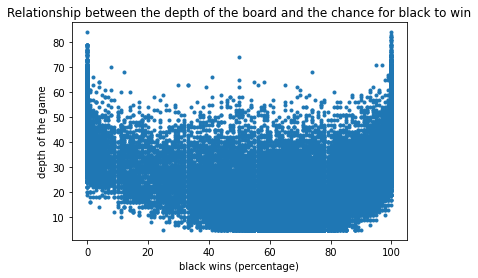

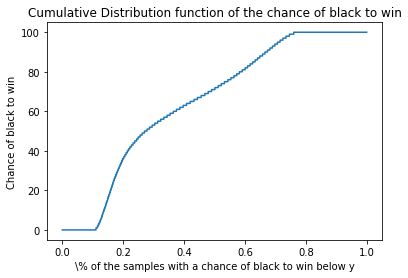

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Relationship between the depth of the board and the chance for black to win")
plt.plot([sample["black_wins"] for sample in data],[sample["depth"] for sample in data], '.')
plt.xlabel("black wins (percentage)")
plt.ylabel("depth of the game")


# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("\% of the samples with a chance of black to win below y")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

# First steps: transform all the data into numpy arrays to feed your neural network

Advices:
- do not use only a 9x9 matrix as input. Use at least two planes to encode the board. One plane for black and one plane for white (typically with a 1 if there is a black stone for the first plane and with a 1 if there is a white stone for the second plane). The dimension of an input should be at least `[9,9,2]`.
- consider to enrich your dataset with all symmetries and rotations. You should be able to multiply the number of samples to consider: any rotation of the board should have the same score, right?
- what should happen on the score if you switch the colors? To know which player has to play next, you can check, for a sample, the parity of the length of the list `data[i]["list_of_moves"]` (an odd length list would mean that white is the next player. An even length list means that black has to play).
- work on enlarging and preparing your data only once. Once all you input data is setup as a big Numpy matrix, you may want to save it for speeding up everything. You can use, for instance `numpy.rot90()` and `numpy.flipud()` to generate all the symmetries



In [5]:
def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

def data_numpy_array(data):
    '''
      We didn't use rot90 and flipud, because of the the time they takes to generates data.
      The idea of rotation/symmetrie is simple, and it's implemented in this function
    '''
    len_data = len(data)
    array_data = np.zeros((len_data,9,9,2), dtype = "int8")
    array_data = np.zeros((7*len_data,9,9,2), dtype = "int8")
    Y = np.zeros(7*len_data, dtype="float64")
    index = 0
    for i in range(len_data):
        for b in data[i]["black_stones"]:
            y_value = data[i]["black_wins"]/100
            (col,lin) = name_to_coord(b)
            array_data[index][lin][col][0] = 1
            Y[index] = y_value
            #First rotation
            (col,lin) = (8-lin,col)
            array_data[index+1][lin][col][0] = 1
            Y[index+1] = y_value
            #Second rotation
            (col,lin) = (8-lin,col)
            array_data[index+2][lin][col][0] = 1
            Y[index+2] = y_value
            #Third rotation
            (col,lin) = (8-lin,col)
            array_data[index+3][lin][col][0] = 1
            Y[index+3] = y_value

            (col,lin) = name_to_coord(b)
            #First symmetrie
            (col,lin) = (8-col,lin)
            array_data[index+4][lin][col][0] = 1
            Y[index+4] = y_value

            (col,lin) = name_to_coord(b)
            #Second symmetrie
            (col,lin) = (col,8-lin)
            array_data[index+5][lin][col][0] = 1
            Y[index+5] = y_value
            #Double symmetrie
            (col,lin) = (8-col,lin)
            array_data[index+6][lin][col][0] = 1
            Y[index+6] = y_value

        for w in data[i]["white_stones"]:
            (col,lin) = name_to_coord(w)
            array_data[index][lin][col][1] = 1
            (col,lin) = (8-lin,col)
            array_data[index+1][lin][col][1] = 1
            (col,lin) = (8-lin,col)
            array_data[index+2][lin][col][1] = 1
            (col,lin) = (8-lin,col)
            array_data[index+3][lin][col][1] = 1

            (col,lin) = name_to_coord(b)
            (col,lin) = (8-col,lin)
            array_data[index+4][lin][col][1] = 1

            (col,lin) = name_to_coord(b)
            (col,lin) = (col,8-lin)
            array_data[index+5][lin][col][1] = 1
            (col,lin) = (8-col,lin)
            array_data[index+6][lin][col][1] = 1
        index += 7
    return array_data , Y

import os.path
X, Y =  "", ""
file_training_X = "training_data_X.npy"
file_training_Y = "training_data_Y.npy"
if (os.path.exists(file_training_X) and os.path.exists(file_training_Y)):
    with open(file_training_X, 'rb') as f:
        X = np.load(f)
    with open(file_training_Y, 'rb') as f:
        Y = np.load(f)
else:
    X, Y = data_numpy_array(data)
    with open(file_training_X, 'wb') as f:
        np.save(f, X)  
    with open(file_training_Y, 'wb') as f:
        np.save(f, Y)

print("data prepared length is",X.shape[0])

data prepared length is 290941


# Second steps: build your neural network and train it

Don't forget to check overfitting, ...

*advices* :
- you need to test Dense and Conv2D layers (the best models may contain convolution layers=
- if you use convolution layers, be sure not to downsize your board. Applying a filter should keep the original size of the board (9x9), otherwise you would somehow forget the stones on the borders
- you will use like 33% of your input sample for validation. However, the final goal is to score new data that will be given in addition to the actual data. So, you should use the 33% splitting rule to set up your network architecture and, once you fixed it, you should train your final model on the whole set of data, crossing your fingers that it will generalize well.
- Warning: if you launch the fit function from keras more than once, it will not reset the weights and the biases of your neural network. It's good news because you can add more and more epochs to your model, but be careful about the training/test sets: each time you call fit() with validation_split set up to something like 0.33, it will choose a **new** partition of the samples. So you are breaking your validation/training partition! We advice you to use the `sklearn.model_selection.train_test_split()` method to split the set of examples just once and then use the parameter `validation_data` in the call for `fit()`.  Thus you will be able to call it multiple time.


In [6]:
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, Add
import tensorflow.keras.optimizers as optimizers

Input_shape = Input(shape=(9, 9, 2))
filters_number = 18
res_block_number = 5

'''
    The model is inspired from the reel model used in AlphaZero from the following pdf:
    https://www.biostat.wisc.edu/~craven/cs760/lectures/AlphaZero.pdf
    We reduced the parameters as number of filters considering that we are working on a small board 9x9
'''
def conv_block(inp):
    '''
        Modules applied in convolutional block
        The block is created with a convolution then batch nomalization
    '''
    inp = Conv2D(filters=filters_number,
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same')(inp)
    inp = BatchNormalization()(inp)
    return inp

def res_block(inp):
    '''
        Modules applied in residual block
        The block is prepared first with convolution, batch normalization, conv and batch normalization the it's added
        to the actuel input
    '''
    block = Conv2D(filters=filters_number,
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same')(inp)
    block = BatchNormalization()(block)
    block = Conv2D(filters=filters_number,
                 kernel_size=(3, 3),
                 activation='relu',
                 padding='same')(block)
    block = BatchNormalization()(block)
    return Add()([block,inp])

inp = conv_block(Input_shape)

for i in range(res_block_number):
    inp = res_block(inp)

inp = Flatten()(inp)

inp = Dense(82, activation='relu')(inp)
inp = Dense(41, activation='relu')(inp)
out = Dense(20, activation='relu')(inp)
out = Dense(1, activation='sigmoid')(inp)

model = Model(Input_shape,out)

'''
    First model implemented
model = Sequential()
model.add(Conv2D(filters=48,
                 kernel_size=(3, 3),
                 activation='tanh',
                 padding='valid',
                 input_shape=(9,9,2)))
model.add(BatchNormalization())
model.add(Conv2D(48, (3, 3),
                 padding='valid',
                 activation='tanh'))
model.add(BatchNormalization())
model.add(Conv2D(filters=48,
                 kernel_size=(3, 3),
                 activation='tanh',
                 padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(48, (3, 3),
                 padding='valid',
                 activation='tanh'))
model.add(Flatten())

model.add(Dense(512, activation='tanh'))
model.add(Dense(9 * 9, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
'''

model.compile(optimizer="sgd", metrics=["mae"], loss="mse")
print("---------- Summary ----------")
model.summary()

#Trainning Section
train_samples = int(0.67 * len(X)) # 33% for test

X_train, X_test = X[:train_samples], X[train_samples:]
Y_train, Y_test = Y[:train_samples], Y[train_samples:]

model.fit(X_train, Y_train, batch_size= 10, epochs= 20, verbose=1, validation_data=(X_test,Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

---------- Summary ----------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 9, 9, 2)]    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 9, 9, 18)     342         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 9, 9, 18)     72          conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 9, 9, 18)     2934        batch_normalization_11[0][0]     
______________________________________________________________

# Last step

Prepare your model to predict the set of new data to predict, you will have only 6 hours to push your predictions.

(may be you would like to express, when guessing the percentage of wins for blacks, that it should reflect the fact that this score should be the same for all the symmetries you considered)...

In [8]:
def get_test_data_go():
    ''' Returns the set of data for test from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    test_file = "positions-to-evaluate-9x9.json.gz"

    if not os.path.isfile(test_file):
        print("File", test_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz", "positions-to-evaluate-9x9.json.gz")
        print(" Done")

    with gzip.open("positions-to-evaluate-9x9.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

test_data = get_test_data_go()
print("We have", len(data),"examples")
create_result_file(test_data)

We have 41563 examples
